#### Importing Libraries

In [32]:
import qiskit as q
import qiskit.visualization as qv
import numpy as np

from qiskit import IBMQ, Aer
from qiskit.providers.ibmq import least_busy
from qiskit import QuantumCircuit, transpile, assemble
from qiskit.tools.monitor import job_monitor
from qiskit.circuit.library import GroverOperator

import matplotlib.style
import matplotlib as plt
plt.style.use("dark_background")

#### Defining oracles Uf and Ur

In [126]:
def Uf(n, num):
    circuit = QuantumCircuit(n+1,name = "Uf")
    x = np.binary_repr(num, n)[::-1]
    for i, j in enumerate(x):
        if j == "0":
            circuit.x(i)
    
    circuit.mcx(list(range(n)),n)
    
    for i, j in enumerate(x):
        if j == "0":
            circuit.x(i)
    
    return circuit
print("Uf Circuit:")
Uf(3,5).draw()

Uf Circuit:


q_0: ───────■───────
     ┌───┐  │  ┌───┐
q_1: ┤ X ├──■──┤ X ├
     └───┘  │  └───┘
q_2: ───────■───────
          ┌─┴─┐     
q_3: ─────┤ X ├─────
          └───┘

In [127]:
def diffuser(n):
    circuit = QuantumCircuit(n+1, name ="diffuser")
    circuit.h(range(n))
    circuit.x(range(n))
    circuit.mcx(list(range(n)),n)
    circuit.x(range(n))
    circuit.h(range(n))
    return circuit
print("diffuser Circuit:")
diffuser(3).draw()

diffuser Circuit:


┌───┐┌───┐     ┌───┐┌───┐
q_0: ┤ H ├┤ X ├──■──┤ X ├┤ H ├
     ├───┤├───┤  │  ├───┤├───┤
q_1: ┤ H ├┤ X ├──■──┤ X ├┤ H ├
     ├───┤├───┤  │  ├───┤├───┤
q_2: ┤ H ├┤ X ├──■──┤ X ├┤ H ├
     └───┘└───┘┌─┴─┐└───┘└───┘
q_3: ──────────┤ X ├──────────
               └───┘

In [122]:
n = 4; num = 10

grover = QuantumCircuit(n+1,n)
nsol = 1 # No. of Solutions

# Initialize the total number of times we pass the oracles
r = int(np.floor(np.pi/4*np.sqrt(2**n)/nsol))

grover.h(range(n))

#Initiate Last Qubit in |-> state
grover.x(n) 
grover.h(n) 

#Apply r rounds of Uf and Diffuser Circuits
for i in range(r):
    grover.append( Uf(n, num), grover.qubits[0:n+1] )
    grover.append( diffuser(n), grover.qubits[0:n+1] )

grover.measure(range(n),range(n))
grover.draw()

┌───┐     ┌─────┐┌───────────┐┌─────┐┌───────────┐┌─────┐┌───────────┐┌─┐»
q_0: ┤ H ├─────┤0    ├┤0          ├┤0    ├┤0          ├┤0    ├┤0          ├┤M├»
     ├───┤     │     ││           ││     ││           ││     ││           │└╥┘»
q_1: ┤ H ├─────┤1    ├┤1          ├┤1    ├┤1          ├┤1    ├┤1          ├─╫─»
     ├───┤     │     ││           ││     ││           ││     ││           │ ║ »
q_2: ┤ H ├─────┤2 Uf ├┤2 diffuser ├┤2 Uf ├┤2 diffuser ├┤2 Uf ├┤2 diffuser ├─╫─»
     ├───┤     │     ││           ││     ││           ││     ││           │ ║ »
q_3: ┤ H ├─────┤3    ├┤3          ├┤3    ├┤3          ├┤3    ├┤3          ├─╫─»
     ├───┤┌───┐│     ││           ││     ││           ││     ││           │ ║ »
q_4: ┤ X ├┤ H ├┤4    ├┤4          ├┤4    ├┤4          ├┤4    ├┤4          ├─╫─»
     └───┘└───┘└─────┘└───────────┘└─────┘└───────────┘└─────┘└───────────┘ ║ »
c: 4/═══════════════════════════════════════════════════════════════════════╩═»
                                                                            0 »
«              
«q_0: ─────────
«     ┌─┐      
«q_1: ┤M├──────
«     └╥┘┌─┐   
«q_2: ─╫─┤M├───
«      ║ └╥┘┌─┐
«q_3: ─╫──╫─┤M├
«      ║  ║ └╥┘
«q_4: ─╫──╫──╫─
«      ║  ║  ║ 
«c: 4/═╩══╩══╩═
«      1  2  3

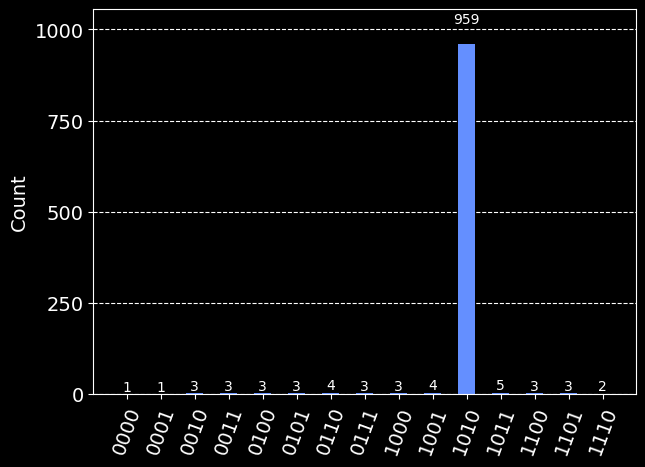

In [123]:
aer_sim = Aer.get_backend('aer_simulator')
shots = 1000
t_grover = transpile(grover, aer_sim)
results = aer_sim.run(t_grover, shots=shots).result()
answer = results.get_counts()

qv.plot_histogram(answer)